## Reading in all subject-level data, combining them into larger structures, saving results for statistical analysis, and performing basic plots


In [2]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats

def jitter(values,j):
    return values + np.random.normal(j,0.1,values.shape)

In [3]:
folders = glob.glob("../data/00_gaze_data/sub*")
folders.sort()
subjs = []
for f in folders:
    subjs.append(f[-6:])
print(len(subjs))   
print(subjs)

# create a list of condition values (which is stored as 1/2 in the main subject memory file
memory_df = pd.read_csv('../data/01_interview_data/recall_vr_driving_e.csv')
subj_restrict_counter = 39
memory_df = memory_df.loc[:subj_restrict_counter]
replacement_mapping = {1: "count trash", 2: "free viewing"}
condition_index = [replacement_mapping.get(item, item) for item in memory_df['condition'].values]
print(condition_index)

40
['sub001', 'sub002', 'sub003', 'sub004', 'sub005', 'sub006', 'sub007', 'sub008', 'sub009', 'sub010', 'sub011', 'sub012', 'sub013', 'sub014', 'sub015', 'sub016', 'sub017', 'sub018', 'sub019', 'sub020', 'sub021', 'sub022', 'sub023', 'sub024', 'sub025', 'sub026', 'sub027', 'sub028', 'sub029', 'sub030', 'sub031', 'sub032', 'sub033', 'sub034', 'sub035', 'sub036', 'sub037', 'sub038', 'sub039', 'sub040']


### Create the LargeDf 

This df stacks all information, i.e. every subject (of 40), every billboard (of 20), whether it was fixated, how often, for how long overall (if fixated), and whether it was recalled and recognized.

In [49]:
list_of_dataframes = []

for i in range(len(subjs)): 
    read_file_name = '../data/03_fixation_billboards_recall_recognition/'  + subjs[i] +'_fixations_billboards_recall_recognition_emointegrated.csv'
    df = pd.read_csv(read_file_name, index_col = 0)
    df['subject'] = subjs[i]
    df["condition"] = condition_index[i]

    #make all a bit prettier
    df['billboard#_fixated'] = np.where(df['fix_bill'] > 0, 1, 0)
    new_column_names = {'position_index': 'position_index', 'billboard_image_at_position_text': 'billboard_image_at_position', 'billboard_image_at_position_text_emotion': 'billboard_emotion',
                       'fix_bill': 'fix_bill', 'billboard#_fixated_count': 'billboard#_fixated_count', 'billboard#_duration': 'billboard#_duration', 
                       'recall': 'recall', 'recognition': 'recognition', 'subject': 'subject',   'condition': 'condition'}
    df = df.rename(columns=new_column_names)
    df['billboard_emotionality'] = df['billboard_emotion'].apply(lambda x: 'high_emo' if '_emo' in x else 'low_emo')

    df = df.drop(columns=['fix_bill', 'billboard_emotion'])
    
    # Replace the column names and order as needed
    new_column_order = ['subject', 'condition', 'position_index', 'billboard_image_at_position', 'billboard_emotionality', 
                       'billboard#_fixated', 'billboard#_fixated_count', 'billboard#_duration', 'recall', 'recognition']
    df = df[new_column_order]
    
    list_of_dataframes.append(df)
    
large_df = pd.concat(list_of_dataframes)

#large_df['billboard_emotionality'] = df['billboard_image_at_position_text_emotion'].str.contains('_emo').astype(float)



#commenting out saving
large_df.to_csv('../data/04_statistics/csv/00_largedf_subject_cond_pos_billb_emo_fix_dur_recall_recognition.csv')

large_df.tail()

,subject,condition,position_index,billboard_image_at_position,billboard_emotionality,billboard#_fixated,billboard#_fixated_count,billboard#_duration,recall,recognition
15,sub040,count trash,16,HIV,low_emo,0,0.0,0.00,0,1
16,sub040,count trash,17,furniture,high_emo,1,1.0,1.78,0,0
17,sub040,count trash,18,sun_protection,low_emo,1,1.0,0.86,0,0
18,sub040,count trash,19,hotel,high_emo,1,2.0,1.20,0,1
19,sub040,count trash,20,brunch,low_emo,1,1.0,1.52,1,1


### Create the BySubjectDf

This df pivots the data by subjects, i.e. so that we have subject level information about condition, number of unique billboards fixated, duration etc.... We also compute rates for the fixation, recall, and recognition, respectively.

In [41]:
bysubject_df.columns

Index(['subject', 'condition', 'billboard_emotionality', 'billboard#_fixated',
       'billboard#_duration', 'recall', 'recognition', 'fixated_rate',
       'recall_rate', 'recognition_rate'],
      dtype='object')

In [48]:
bysubject_df = large_df.groupby(['subject', 'condition', 'billboard_emotionality']).agg({'billboard#_fixated':'sum', 'billboard#_duration':'sum', 'recall':'sum', 'recognition':'sum'})
bysubject_df.reset_index(inplace=True)

bysubject_df['fixated_rate']      = bysubject_df['billboard#_fixated']/10
bysubject_df['recall_rate']      = bysubject_df['recall']/10
bysubject_df['recognition_rate'] = bysubject_df['recognition']/10
bysubject_df = bysubject_df.drop(columns=['recall', 'recognition', 'billboard#_fixated'])

bysubject_df.head()

g2 = bysubject_df.pivot(index='subject', columns='billboard_emotionality', values = ['condition', 'fixated_rate', 'billboard#_duration', 'recall_rate', 'recognition_rate'] )
g2.columns = g2.columns.map('_'.join)
g2 = g2.drop(columns=['condition_high_emo'])
g2.rename(columns={'condition_low_emo': 'condition'}, inplace=True)


g2.to_csv('../data/04_statistics/csv/01_bysubjectdf_billboard_fixations_durations_recall_recognition_bysubject_bycondition.csv')
g2.head()



,condition,fixated_rate_high_emo,fixated_rate_low_emo,billboard#_duration_high_emo,billboard#_duration_low_emo,recall_rate_high_emo,recall_rate_low_emo,recognition_rate_high_emo,recognition_rate_low_emo
subject,,,,,,,,,
sub001,count trash,0.0,0.3,0.0,3.45,0.0,0.0,0.0,0.0
sub002,count trash,1.0,1.0,13.46,16.27,0.2,0.3,0.8,0.4
sub003,count trash,0.3,0.4,2.46,8.73,0.0,0.2,0.0,0.3
sub004,count trash,0.9,0.9,14.77,10.26,0.2,0.4,0.8,0.8
sub005,count trash,1.0,1.0,30.68,33.93,0.2,0.2,0.8,0.8


### Visualize Viewing Behavior as a Function of Driving Condition

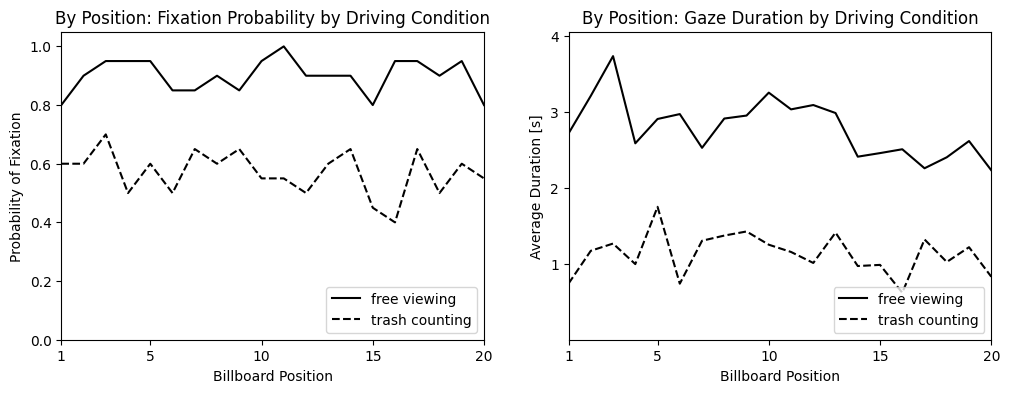

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

by_pos_df_trash = large_df[large_df['condition']=='count trash'].groupby('position_index').agg({'billboard#_fixated':'mean'})
by_pos_df_free = large_df[large_df['condition']=='free viewing'].groupby('position_index').agg({'billboard#_fixated':'mean'})

by_pos_df_free.plot(label='free viewing',color = 'black',  ax = ax1)
by_pos_df_trash.plot(label='trash counting', color = 'black', linestyle='--', ax = ax1)

ax1.set_ylim([0,1.05])
ax1.set_ylabel('Probability of Fixation')
ax1.set_xlabel('Billboard Position')
ax1.set_xlim([1,20])
ax1.set_xticks( [1, 5, 10, 15, 20])
ax1.set_xticklabels( [1, 5, 10, 15, 20])
ax1.legend([ "free viewing", "trash counting"], loc='lower right');
ax1.set_title('By Position: Fixation Probability by Driving Condition');

# 
by_pos_df_trash = large_df[large_df['condition']=='count trash'].groupby('position_index').agg({'billboard#_duration':'mean'})
by_pos_df_free = large_df[large_df['condition']=='free viewing'].groupby('position_index').agg({'billboard#_duration':'mean'})

by_pos_df_free.plot(label='free viewing', color = 'black',  ax = ax2)
by_pos_df_trash.plot(label='trash counting', color = 'black', linestyle='--',  ax = ax2)

ax2.set_ylim([0,4.05])
ax2.set_ylabel('Average Duration [s]')
ax2.set_xlabel('Billboard Position')
ax2.set_xlim([1,20])
ax2.set_xticks( [1, 5, 10, 15, 20])
ax2.set_xticklabels( [1, 5, 10, 15, 20])
ax2.set_yticks(range(1, 5, 1));
ax2.legend([ "free viewing", "trash counting"], loc='lower right');
ax2.set_title('By Position: Gaze Duration by Driving Condition');


we can see above that there's a strong effect of Driving Condition: Much more fixations in the free viewing condition (left) and much longer gaze duration (right)




### Visualize Viewing Behavior as a Function of Driving Condition

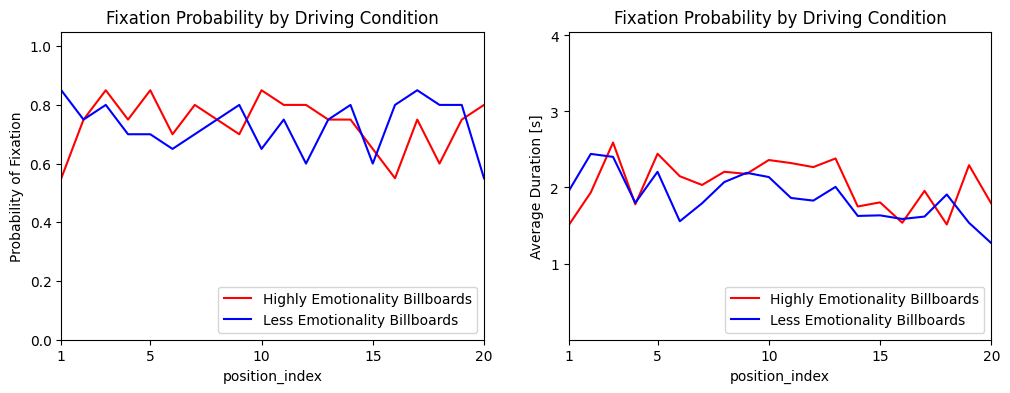

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

by_pos_df_high_emo = large_df[large_df['billboard_emotionality']=='high_emo'].groupby('position_index').agg({'billboard#_fixated':'mean'})
by_pos_df_low_emo = large_df[large_df['billboard_emotionality']=='low_emo'].groupby('position_index').agg({'billboard#_fixated':'mean'})

by_pos_df_high_emo.plot(label='Highly Emotionality Billboards', ax = ax1, color = 'red')
by_pos_df_low_emo.plot(label='Less Emotional Billboards', ax = ax1, color = 'blue')

ax1.set_ylim([0,1.05])
ax1.set_ylabel('Probability of Fixation')
ax1.set_xlim([1,20])
ax1.set_xticks( [1, 5, 10, 15, 20])
ax1.set_xticklabels( [1, 5, 10, 15, 20])
ax1.legend([ "Highly Emotionality Billboards", "Less Emotionality Billboards"], loc='lower right');
ax1.set_title('Fixation Probability by Driving Condition');


#
by_pos_df_high_emo = large_df[large_df['billboard_emotionality']=='high_emo'].groupby('position_index').agg({'billboard#_duration':'mean'})
by_pos_df_low_emo = large_df[large_df['billboard_emotionality']=='low_emo'].groupby('position_index').agg({'billboard#_duration':'mean'})

by_pos_df_high_emo.plot(label='Highly Emotionality Billboards', ax = ax2, color = 'red')
by_pos_df_low_emo.plot(label='Less Emotional Billboards', ax = ax2, color = 'blue')

ax2.set_ylim([0,4.05])
ax2.set_ylabel('Average Duration [s]')
ax2.set_xlim([1,20])
ax2.set_xticks( [1, 5, 10, 15, 20])
ax2.set_xticklabels( [1, 5, 10, 15, 20])
ax2.set_yticks( [1,2,3,4])
ax2.set_yticklabels( [1,2,3,4])
ax2.legend([ "Highly Emotionality Billboards", "Less Emotionality Billboards"], loc='lower right');
ax2.set_title('Fixation Probability by Driving Condition');




we see that there is not much evidence of strong emotionality effects (but some could be there). See statistics for further examination.



### Gradient Analysis
The goal of this analysis is to go over every individual participant, find out how often they fixated a given billboard (same could be done with the duration). We will then form three bins (taking into account variability across subjects): Billboards that were never fixated, billboards that the given subject fixated somewhat, but not very often; and finally, billboards that the subject fixated multiple times.

In [18]:
# for recall
subjres = []

for i in range(len(subjs)):
    res = np.zeros(3)
    
    df = large_df[large_df['subject'] == subjs[i]]
    curr_sub_med_fix = df[ df['billboard#_fixated_count']!=0]['billboard#_fixated_count'].median()

    res[0] = df[ df['billboard#_fixated_count']==0]['recall'].sum()

    interim_df = df[ df['billboard#_fixated_count'] > 0 ]
    interim_df = interim_df[ interim_df['billboard#_fixated_count'] < curr_sub_med_fix ] #less than median fixation
    res[1] = interim_df['recall'].sum()    

    res[2] = df[ df['billboard#_fixated_count']>=curr_sub_med_fix]['recall'].sum()  # more than median fixations (
    
    subjres.append(res)
    
subj_df = pd.DataFrame(np.asarray(subjres), columns = ['not_fixated_recalled', 'some_fixated_recalled','alot_fixated_recalled'])
subj_df['subject'] = subjs
subj_df['condition'] = condition_index

#commenting out saving
subj_df.to_csv('../data/04_statistics/csv/02_gradientdf_billboard_fixation_recall.csv')


# for recognition
subjres = []

for i in range(len(subjs)):
    res = np.zeros(3)
    
    df = large_df[large_df['subject'] == subjs[i]]
    curr_sub_med_fix = df[ df['billboard#_fixated_count']!=0]['billboard#_fixated_count'].median()

    res[0] = df[ df['billboard#_fixated_count']==0]['recognition'].sum()

    interim_df = df[ df['billboard#_fixated_count'] > 0 ]
    interim_df = interim_df[ interim_df['billboard#_fixated_count'] < curr_sub_med_fix ] #less than median fixation
    res[1] = interim_df['recognition'].sum()    

    res[2] = df[ df['billboard#_fixated_count']>=curr_sub_med_fix]['recognition'].sum()  # more than median fixations (
    
    subjres.append(res)
    
subj_df = pd.DataFrame(np.asarray(subjres), columns = ['not_fixated_recognized', 'some_fixated_recognized','alot_fixated_recognized'])
subj_df['subject'] = subjs
subj_df['condition'] = condition_index
subj_df
#commenting out saving
#subj_df.to_csv('../data/04_statistics/csv/03_gradientdf_billboard_fixation_recognition.csv')

,not_fixated_recognized,some_fixated_recognized,alot_fixated_recognized,subject,condition
0,0.0,0.0,0.0,sub001,count trash
1,0.0,5.0,7.0,sub002,count trash
2,0.0,0.0,3.0,sub003,count trash
3,2.0,6.0,8.0,sub004,count trash
4,0.0,7.0,9.0,sub005,count trash
5,0.0,2.0,10.0,sub006,count trash
6,0.0,2.0,10.0,sub007,count trash
7,4.0,1.0,1.0,sub008,count trash
8,3.0,3.0,7.0,sub009,count trash
9,5.0,0.0,2.0,sub010,count trash


In [108]:
res = large_df.groupby(['subject', 'condition']).agg({'billboard#_fixated':'sum', 'billboard#_duration':'sum', 'recall':'sum', 'recognition':'sum'})
res.reset_index(inplace=True)
res['recall_rate'] = res['recall']/20
res['recognition_rate'] = res['recognition']/20
#res.to_csv('../data/04_statistics/csv/billboard_fixations__durations_recall_recognition_bysubject_bycondition.csv')

In [25]:
grouped = large_df.groupby(['subject', 'billboard_emotionality', 'condition']).agg({'billboard#_fixated':'sum', 'billboard#_duration':'sum',  'recall':'sum', 'recognition':'sum'})
grouped.reset_index(inplace=True)
grouped

high_low_emo_fixbinarized = grouped.pivot(index='subject', columns='billboard_emotionality', values = ['billboard#_fixated', 'billboard#_duration', 'recall', 'recognition'] )
high_low_emo_fixbinarized.columns = high_low_emo_fixbinarized.columns.map('_'.join)
high_low_emo_fixbinarized.to_csv('../data/04_statistics/csv/billboad_fixation_duration_recall_recognition_emo_high_emo_low.csv')
high_low_emo_fixbinarized.head()

,billboard#_fixated_high_emo,billboard#_fixated_low_emo,recall_high_emo,recall_low_emo,recognition_high_emo,recognition_low_emo
subject,,,,,,
sub001,0,3,0,0,0,0
sub002,10,10,2,3,8,4
sub003,3,4,0,2,0,3
sub004,9,9,2,4,8,8
sub005,10,10,2,2,8,8


In [26]:
by_subject_df = large_df.groupby('subject').agg({'billboard#_fixated':'sum', 'recall':'sum', 'recognition':'sum'})
#by_subject_df = by_subject_df.drop(columns = "fix_binarized")
by_subject_df['recall_rate'] = by_subject_df['recall']/20 
by_subject_df['recognition_rate'] = by_subject_df['recognition']/20 
by_subject_df.head()

,billboard#_fixated,recall,recognition,recall_rate,recognition_rate
subject,,,,,
sub001,3,0,0,0.00,0.00
sub002,20,5,12,0.25,0.60
sub003,7,2,3,0.10,0.15
sub004,18,6,16,0.30,0.80
sub005,20,4,16,0.20,0.80


### Plot

In [121]:
large_df[['billboard#_fixated_count', 'billboard_emotionality']].groupby('billboard_emotionality').agg({'billboard#_fixated_count': 'mean'})

,billboard#_fixated_count
billboard_emotionality,
high_emo,2.0450
low_emo,1.9825


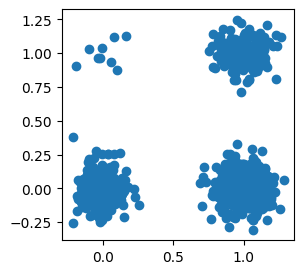

In [124]:
plt.figure(figsize = (3,3,))
plt.scatter(x = jitter(large_df['billboard#_fixated'],0), 
                y = jitter(large_df.recall,0));

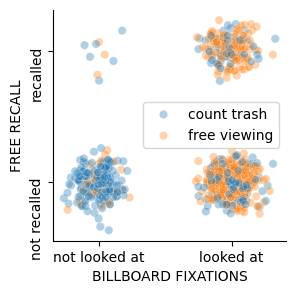

In [125]:
# list with ordered categories
fig, ax = plt.subplots(1, figsize=(3,3))

sns.scatterplot(x = jitter(large_df['billboard#_fixated'],0), 
                y = jitter(large_df.recall,0),
                hue = large_df.condition,
                alpha=0.35,
                );
plt.legend(loc='right');

plt.xticks([0, 1], ['not looked at', 'looked at'])
plt.xlabel('BILLBOARD FIXATIONS');

plt.yticks([0, 1], ['not recalled', 'recalled'])
plt.yticks(rotation=90)
plt.ylabel('FREE RECALL');

sns.despine()

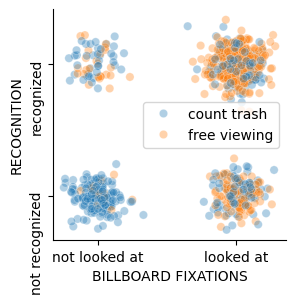

In [126]:
# list with ordered categories
fig, ax = plt.subplots(1, figsize=(3,3))

sns.scatterplot(x = jitter(large_df['billboard#_fixated'],0), 
                y = jitter(large_df.recognition,0),
                hue = large_df.condition,
                alpha=0.35,
                );
plt.legend(loc='right');

plt.xticks([0, 1], ['not looked at', 'looked at'])
plt.xlabel('BILLBOARD FIXATIONS');

plt.yticks([0, 1], ['not recognized', 'recognized'])
plt.yticks(rotation=90)
plt.ylabel('RECOGNITION');

sns.despine()

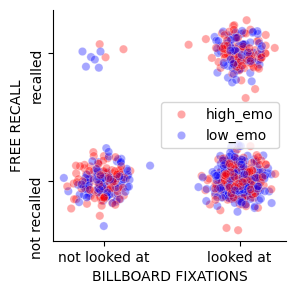

In [127]:
custom_palette = {'high_emo': 'red', 'low_emo': 'blue'}

fig, ax = plt.subplots(1, figsize=(3,3))

sns.scatterplot(x = jitter(large_df['billboard#_fixated'],0), 
                y = jitter(large_df.recall,0),
                hue = large_df.billboard_emotionality,
                alpha=0.35,
                palette=custom_palette, 
                );
plt.legend(loc='right');

plt.xticks([0, 1], ['not looked at', 'looked at'])
plt.xlabel('BILLBOARD FIXATIONS');

plt.yticks([0, 1], ['not recalled', 'recalled'])
plt.yticks(rotation=90)
plt.ylabel('FREE RECALL');

sns.despine()

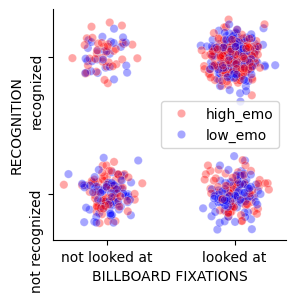

In [128]:
custom_palette = {'high_emo': 'red', 'low_emo': 'blue'}

fig, ax = plt.subplots(1, figsize=(3,3))

sns.scatterplot(x = jitter(large_df['billboard#_fixated'],0), 
                y = jitter(large_df.recognition,0),
                hue = large_df.billboard_emotionality,
                alpha=0.35,
                palette=custom_palette, 
                );
plt.legend(loc='right');

plt.xticks([0, 1], ['not looked at', 'looked at'])
plt.xlabel('BILLBOARD FIXATIONS');

plt.yticks([0, 1], ['not recognized', 'recognized'])
plt.yticks(rotation=90)
plt.ylabel('RECOGNITION');

sns.despine()

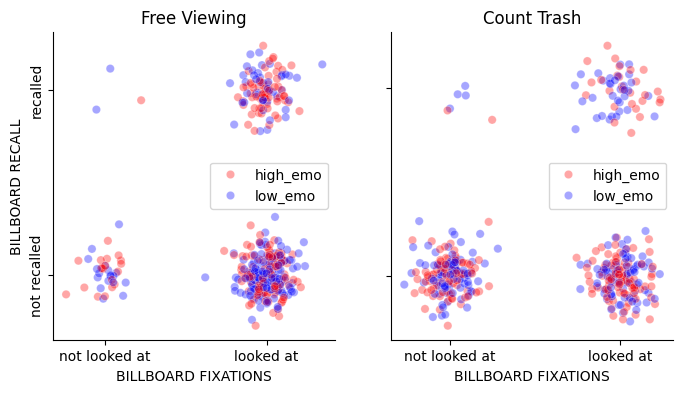

In [129]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.set_title('Free Viewing')
sub_df = large_df[large_df['condition'] == 'free viewing']
custom_palette1 = {'high_emo': 'red', 'low_emo': 'blue'}
sns.scatterplot(data = sub_df,
                x = jitter(sub_df['billboard#_fixated'],0), 
                y = jitter(sub_df.recall,0),
                hue = sub_df.billboard_emotionality,
                alpha=0.35,
                palette=custom_palette1, 
                ax = ax1);

ax1.legend(loc='right');
ax1.set_xticks([0, 1], ['not looked at', 'looked at'])
ax1.set_xlabel('BILLBOARD FIXATIONS');
ax1.set_yticks([0, 1], ['not recalled', 'recalled'], rotation=90, verticalalignment='center')
ax1.set_ylabel('BILLBOARD RECALL');


ax2.set_title('Count Trash')
sub_df = large_df[large_df['condition'] == 'count trash']
custom_palette2 = {'high_emo': 'red', 'low_emo': 'blue'}
sns.scatterplot(data = sub_df,
                x = jitter(sub_df['billboard#_fixated'],0), 
                y = jitter(sub_df.recall,0),
                hue = sub_df.billboard_emotionality,
                alpha=0.35,
                palette=custom_palette2, 
                ax = ax2);

ax2.legend(loc='right');
ax2.set_xticks([0, 1], ['not looked at', 'looked at'])
ax2.set_xlabel('BILLBOARD FIXATIONS');
ax2.set_yticks([0, 1], [' ', ' '], rotation=90, verticalalignment='center')
ax2.set_ylabel(' ');

sns.despine()

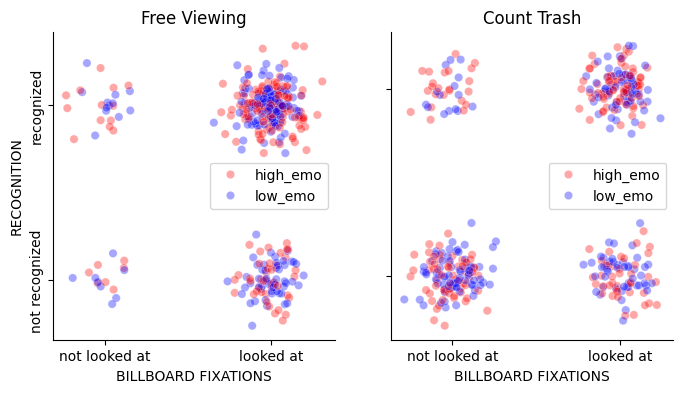

In [130]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.set_title('Free Viewing')
sub_df = large_df[large_df['condition'] == 'free viewing']
custom_palette1 = {'high_emo': 'red', 'low_emo': 'blue'}
sns.scatterplot(data = sub_df,
                x = jitter(sub_df['billboard#_fixated'],0), 
                y = jitter(sub_df.recognition,0),
                hue = sub_df.billboard_emotionality,
                alpha=0.35,
                palette=custom_palette1, 
                ax = ax1);

ax1.legend(loc='right');
ax1.set_xticks([0, 1], ['not looked at', 'looked at'])
ax1.set_xlabel('BILLBOARD FIXATIONS');
ax1.set_yticks([0, 1], ['not recognized', 'recognized'], rotation=90, verticalalignment='center')
ax1.set_ylabel('RECOGNITION');


ax2.set_title('Count Trash')
sub_df = large_df[large_df['condition'] == 'count trash']
custom_palette2 = {'high_emo': 'red', 'low_emo': 'blue'}
sns.scatterplot(data = sub_df,
                x = jitter(sub_df['billboard#_fixated'],0), 
                y = jitter(sub_df.recognition,0),
                hue = sub_df.billboard_emotionality,
                alpha=0.35,
                palette=custom_palette2, 
                ax = ax2);

ax2.legend(loc='right');
ax2.set_xticks([0, 1], ['not looked at', 'looked at'])
ax2.set_xlabel('BILLBOARD FIXATIONS');
ax2.set_yticks([0, 1], [' ', ' '], rotation=90, verticalalignment='center')
ax2.set_ylabel(' ');

sns.despine()

### Gradient analysis

In [131]:
df

,subject,condition,position_index,billboard_image_at_position,billboard_emotionality,billboard#_fixated,billboard#_fixated_count,billboard#_duration,recall,recognition
0,sub040,count trash,1,burger,low_emo,1,1.0,0.87,0,0
1,sub040,count trash,2,tech_addiction,high_emo,1,1.0,2.52,0,1
2,sub040,count trash,3,text_driving,low_emo,1,1.0,0.95,0,1
3,sub040,count trash,4,education_donation,high_emo,1,1.0,2.13,0,0
4,sub040,count trash,5,vaping,high_emo,1,2.0,1.86,1,1
5,sub040,count trash,6,drugged_driving,high_emo,0,0.0,0.00,0,1
6,sub040,count trash,7,diabetes,high_emo,0,0.0,0.00,0,0
7,sub040,count trash,8,marijuana,low_emo,1,2.0,1.68,1,1
8,sub040,count trash,9,wash_hands,low_emo,0,0.0,0.00,0,1
9,sub040,count trash,10,binge_drinking,low_emo,0,0.0,0.00,1,1


### large df

In [34]:
large_df.head()

,position_index,billboard_image_at_position_text,billboard_image_at_position_text_emotion,fix_bill,count,recall,recognition,subject,condition,billboard_emotionality,fix_binarized
0,1,text_driving,text_driving_emo,0.0,0.0,0,0,sub001,count trash,high_emo,0.0
1,2,burger,burger_neu,2.0,1.0,0,0,sub001,count trash,low_emo,1.0
2,3,buckle_up,buckle_up_neu,0.0,0.0,0,0,sub001,count trash,low_emo,0.0
3,4,hotel,hotel_emo,0.0,0.0,0,0,sub001,count trash,high_emo,0.0
4,5,sun_protection,sun_protection_emo,0.0,0.0,0,0,sub001,count trash,high_emo,0.0


In [35]:
grouped = large_df.groupby(['billboard_image_at_position_text', 'billboard_emotionality']).agg({'fix_binarized':'sum', 'fix_binarized':'sum', 'recall':'sum', 'recognition':'sum'})
grouped.reset_index(inplace=True)
grouped

g2 = grouped.pivot(index='billboard_image_at_position_text', columns='billboard_emotionality', values = ['fix_binarized', 'recall', 'recognition'] )
g2.columns = g2.columns.map('_'.join)
g2.to_csv('../data/04_statistics/csv/g2.csv')
g2


,fix_binarized_high_emo,fix_binarized_low_emo,recall_high_emo,recall_low_emo,recognition_high_emo,recognition_low_emo
billboard_image_at_position_text,,,,,,
HIV,14.0,13.0,1.0,3.0,10.0,12.0
binge_drinking,13.0,15.0,8.0,4.0,14.0,10.0
brunch,12.0,17.0,7.0,6.0,11.0,16.0
buckle_up,15.0,14.0,8.0,7.0,17.0,15.0
burger,16.0,15.0,4.0,6.0,14.0,12.0
coffee,18.0,14.0,4.0,3.0,12.0,8.0
diabetes,13.0,9.0,4.0,2.0,13.0,9.0
drugged_driving,14.0,13.0,9.0,6.0,19.0,11.0
education_donation,16.0,17.0,2.0,1.0,9.0,7.0


0.5420287620400687
0.7934335561509611
0.5907005537490216
0.14997194259508165


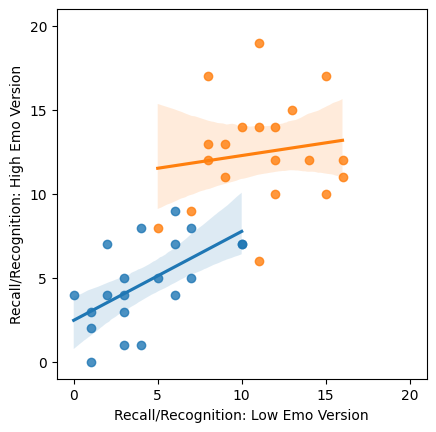

In [77]:
sns.regplot(x = g2['recall_low_emo'],
            y = g2['recall_high_emo'])

sns.regplot(x = g2['recognition_low_emo'],
            y = g2['recognition_high_emo'])

plt.axis('square')
plt.xlim([-1,21])
plt.xticks(range(0, 21,5));
plt.xlabel('Recall/Recognition: Low Emo Version');

plt.ylim([-1,21])
plt.yticks(range(0, 21,5));
plt.ylabel('Recall/Recognition: High Emo Version');



#sns.despine()

print(np.corrcoef(g2['recall_high_emo'], g2['recognition_high_emo'])[0,1])
print(np.corrcoef(g2['recall_low_emo'], g2['recognition_low_emo'])[0,1])

print(np.corrcoef(g2['recall_high_emo'], g2['recall_low_emo'])[0,1])
print(np.corrcoef(g2['recognition_high_emo'], g2['recognition_low_emo'])[0,1])

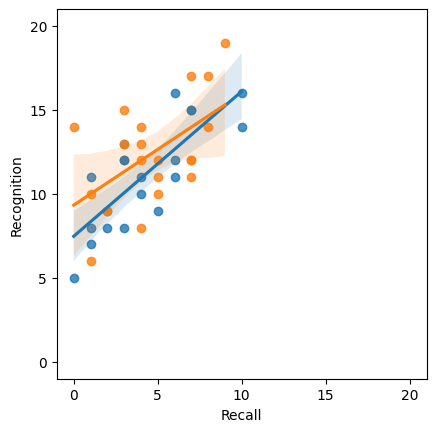

In [79]:
sns.regplot(x = g2['recall_low_emo'],
            y = g2['recognition_low_emo'])

sns.regplot(x = g2['recall_high_emo'],
            y = g2['recognition_high_emo'])

plt.axis('square')
plt.xlim([-1,21])
plt.xticks(range(0, 21,5));
plt.xlabel('Recall');

plt.ylim([-1,21])
plt.yticks(range(0, 21,5));
plt.ylabel('Recognition');


In [35]:
large_df.to_csv('../data/04_statistics/csv/large_df.csv')

In [76]:
g2.corr().round(decimals=2)

,fix_binarized_high_emo,fix_binarized_low_emo,recall_high_emo,recall_low_emo,recognition_high_emo,recognition_low_emo
fix_binarized_high_emo,1.00,0.03,-0.08,-0.20,-0.04,-0.47
fix_binarized_low_emo,0.03,1.00,0.17,0.40,-0.07,0.40
recall_high_emo,-0.08,0.17,1.00,0.59,0.54,0.32
recall_low_emo,-0.20,0.40,0.59,1.00,0.15,0.79
recognition_high_emo,-0.04,-0.07,0.54,0.15,1.00,0.15
recognition_low_emo,-0.47,0.40,0.32,0.79,0.15,1.00


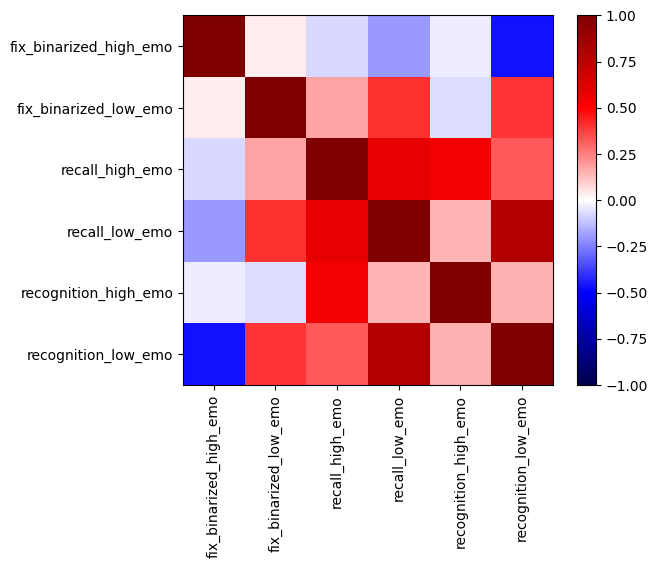

In [70]:
plt.imshow(g2.corr(), cmap = 'seismic', vmin = -1, vmax = 1);
#plt.xtick_label(g2.columns.values)
plt.yticks(range(0,6), g2.columns.values)
plt.xticks(range(0,6), g2.columns.values, rotation = 90)

plt.colorbar();